In [1]:
#@title Speech Emotion classification


# Import Dependencies

In [2]:
!pip3 install nlpaug

     |████████████████████████████████| 399kB 4.2MB/s 


In [3]:
import os
import warnings
warnings.filterwarnings('ignore')
import keras
import librosa

import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.offline as py
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)
from keras.models import Model
from keras.layers import Dense
from keras.layers import Dropout, Input
from keras.utils import np_utils
from keras.models import Model, Sequential
from keras import optimizers
from keras.layers import Input, Conv1D, Conv2D,BatchNormalization, MaxPooling1D,MaxPooling2D, LSTM, Dense, Activation, Layer,Reshape
from keras.models import Model
from keras.layers import Dense, Input
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm_notebook as tqdm
import nlpaug
import nlpaug.augmenter.audio as naa
from nlpaug.util.audio.visualizer import AudioVisualizer
input_duration=3
# % pylab inline

from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input as mobv2_preprocessor
from keras.applications.nasnet import NASNetMobile
from keras.applications.nasnet import preprocess_input as mob_nas_preprocessor
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input as den_preprocessor
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input as mob_preprocessor
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as incv3_preprocessor
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as xcep_preprocessor
from keras.applications.nasnet import NASNetLarge
from keras.applications.nasnet import preprocess_input as nas_preprocessor
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input as resv2_preprocessor

import keras
from keras.layers import Input
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras.layers import InputLayer
from keras.layers import Dropout
from keras.layers import Dense

from tqdm import tqdm_notebook as tqdm

# Configuration setup

In [4]:
import os.path
KAGGLE_USERNAME = 'ankit2771991'    # your kaggle id
KAGGLE_KEY = '7144e70b2d30a62cb874847651deb9f5' # your kaggle api key
DATASET_FOLDER= 'ravdess-emotional-speech-audio'
DATASET_DIRECTORY = os.path.join(DATASET_FOLDER)    #path while execution in google colab 
# DATASET_DIRECTORY = os.path.join('..','input',DATASET_FOLDER) #path while execution in kaggle
# DATASET_DIRECTORY = os.path.join('data_set',DATASET_FOLDER) #path while execution in local

In [5]:
from os import path

if path.isdir(DATASET_DIRECTORY):
  print ("Skipping download as directory exists: " + os.path.realpath(DATASET_DIRECTORY))
else:
  print ("Downloading dataset as directory not found at: " + DATASET_DIRECTORY)
  !pip install --upgrade --force-reinstall --no-deps kaggle

  f = open("kaggle.json", "w")    #create kaggle config to download dataset
  f.write('{"username":"'+KAGGLE_USERNAME+'","key":"'+KAGGLE_KEY+'"}')
  f.close()

  ! mkdir ~/.kaggle
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  ! kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio
  ! mkdir $DATASET_DIRECTORY
  ! unzip ravdess-emotional-speech-audio.zip -d $DATASET_DIRECTORY

     |████████████████████████████████| 61kB 3.2MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=baf5f8d0d562f5386c13e4badfb14214e4595632eccecde091cd5f71134f9b5a
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
 98% 420M/429M [00:16<00:00, 27.4MB/s]
100% 429M/429M [00:16<00:00, 27.3MB/s]
Archive:  ravdess-emotional-speech-audio.zip
  inflating: ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-02-01.wav  
  inflating: ravdess-emotional-speech-audio/Actor_01/03-01-01-01-02-01-01.wav  
  inflating: ravdess-emotional-speech-audio/Actor_01/03-01-01-01-02-02-01.wav  
  inflating: ravdess-emotional-speech-audio/Actor_01/03-01-02-01-01-01-01.wav  
  inflating: rav

In [6]:
# Data Directory
# Please edit according to your directory change.
dir_list = os.listdir(DATASET_DIRECTORY)
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24', 'audio_speech_actors_01-24']


# Data Preprocessing

In [7]:
# Create DataFrame from the given data
ravdess_db = pd.DataFrame(columns=['path','source','actor', 'gender', 'emotion','emotion_lb'])
count = 0
if 'audio_speech_actors_01-24' in dir_list: dir_list.remove('audio_speech_actors_01-24')
dir_list.sort()
for i in dir_list:
    dir = os.path.join(DATASET_DIRECTORY,'audio_speech_actors_01-24' , i)
    file_list = os.listdir(dir)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = os.path.join(dir,f)
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        source = "Ravdess"
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
        if emotion == 1:
            lb = "neutral"
        elif emotion == 2:
            lb = "calm"
        elif emotion == 3:
            lb = "happy"
        elif emotion == 4:
            lb = "sad"
        elif emotion == 5:
            lb = "angry"
        elif emotion == 6:
            lb = "fearful"
        elif emotion == 7:
            lb = "disgust"
        elif emotion == 8:
            lb = "surprised"
        else:
            lb = "none"
        ravdess_db.loc[count] = [path,source,actor, gender, emotion,lb]
        count += 1

In [8]:
ravdess_db.head()

,path,source,actor,gender,emotion,emotion_lb
0,ravdess-emotional-speech-audio/audio_speech_ac...,Ravdess,1,male,7,disgust
1,ravdess-emotional-speech-audio/audio_speech_ac...,Ravdess,1,male,3,happy
2,ravdess-emotional-speech-audio/audio_speech_ac...,Ravdess,1,male,3,happy
3,ravdess-emotional-speech-audio/audio_speech_ac...,Ravdess,1,male,8,surprised
4,ravdess-emotional-speech-audio/audio_speech_ac...,Ravdess,1,male,7,disgust


In [9]:
ravdess_db.drop(ravdess_db.index[ravdess_db['emotion_lb'] == 'surprised'], inplace = True)
ravdess_db.loc[ravdess_db.emotion_lb=='calm',['emotion','emotion_lb']]= 1,'neutral'

Ravdess file distribution graph

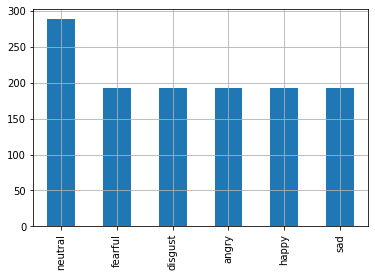

In [10]:
ravdess_db['emotion_lb'].value_counts().plot(kind='bar',grid=True)

In [11]:
# Creating a copy to avoid changing original dataframe
dataset_db = ravdess_db.copy()


In [12]:
# dataset_db.index=range(len(dataset_db.index))
# dataset_db.head()

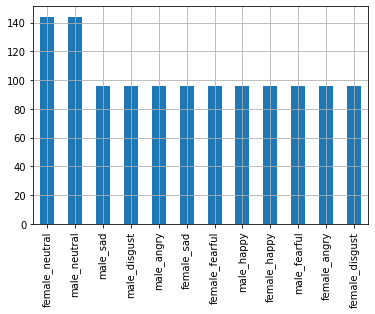

In [13]:
# Adding gender to emotion label
dataset_db.emotion_lb = dataset_db.gender+"_"+dataset_db.emotion_lb
dataset_db['emotion_lb'].value_counts().plot(kind='bar',grid=True)

In [14]:
# dataset_db.index=range(len(dataset_db.index))

In [15]:
# dataset_db.emotion_lb.value_counts()
# dataset_db.sort_values(by=['path'], inplace=True)
# dataset_db.head()

In [16]:
# dataset_db.index = range(len(dataset_db.index))

In [17]:
# # shuffle
dataset_db = dataset_db.sample(frac=1).reset_index(drop=True)
dataset_db

,path,source,actor,gender,emotion,emotion_lb
0,ravdess-emotional-speech-audio/audio_speech_ac...,Ravdess,24,female,1,female_neutral
1,ravdess-emotional-speech-audio/audio_speech_ac...,Ravdess,11,male,6,male_fearful
2,ravdess-emotional-speech-audio/audio_speech_ac...,Ravdess,13,male,7,male_disgust
3,ravdess-emotional-speech-audio/audio_speech_ac...,Ravdess,7,male,6,male_fearful
4,ravdess-emotional-speech-audio/audio_speech_ac...,Ravdess,13,male,3,male_happy
...,...,...,...,...,...,...
1243,ravdess-emotional-speech-audio/audio_speech_ac...,Ravdess,13,male,6,male_fearful
1244,ravdess-emotional-speech-audio/audio_speech_ac...,Ravdess,1,male,3,male_happy
1245,ravdess-emotional-speech-audio/audio_speech_ac...,Ravdess,24,female,5,female_angry
1246,ravdess-emotional-speech-audio/audio_speech_ac...,Ravdess,7,male,1,male_neutral


In [18]:
# configuration for audio processing
audio_duration = 3
sampling_rate = 22050*2
input_length = sampling_rate * audio_duration
n_mfcc = 20

In [19]:
data_sample= np.zeros(input_length)
MFCC = librosa.feature.mfcc(data_sample, sr=sampling_rate, n_mfcc=n_mfcc)

In [20]:
MFCC.shape

(20, 259)

In [21]:
# def get_scale_co(input,in_max,in_min,out_max,out_min):
#   return ((input - in_min) / (in_max - in_min)) * (out_max - out_min) + out_min


In [22]:
# Function to extract MFCC feature
def get_feature(signal,sample_rate):
    signal,index = librosa.effects.trim(signal,top_db = 25)
    signal = scipy.signal.wiener(signal)
    
    if len(signal) > input_length:
        signal = signal[0:input_length]
    elif  input_length > len(signal):
        max_offset = input_length - len(signal)  
        signal = np.pad(signal, (0, max_offset), "constant")

    melspec = librosa.feature.melspectrogram(signal, sr=sample_rate, n_mels=128,n_fft=2048,hop_length=512)   
    logspec = librosa.amplitude_to_db(melspec)
    logspec = np.expand_dims(logspec, axis=-1)
    exp_logspec = np.zeros(shape=(logspec.shape[0],logspec.shape[1],3))
    exp_logspec[:,:,:]=logspec[:,:]
    return exp_logspec

In [23]:
# Function to get processed audio with label
def get_process_audio(sampling_rate,aug=None):
  audios= np.empty(shape=(len(dataset_db),128, MFCC.shape[1], 3))
  audios_label= np.empty(shape=len(audios),dtype=object)


  for i in tqdm(range(len(dataset_db))):
    signal, sample_rate = librosa.load(dataset_db.path[i], res_type='kaiser_fast',sr=sampling_rate)
    if aug is not None:
      signal=aug.augment(signal)
    audios[i,] = get_feature(signal,sample_rate)
    audios_label[i]=dataset_db.emotion_lb[i]
  return audios,audios_label

# Data augmentation

In [24]:
# 
audio_og = get_process_audio(sampling_rate,None)+('Original',)

In [25]:
# Audio augmented with noise
audio_noise = get_process_audio(sampling_rate,naa.NoiseAug())+('Noise',)

In [26]:
# Audio augmented by masking
# audio_mask = get_process_audio(sampling_rate,naa.MaskAug(sampling_rate=sampling_rate, mask_with_noise=False))+('Mask',)

In [27]:
# Audio augmented by performing a shift
# audio_shift = get_process_audio(sampling_rate,naa.ShiftAug(sampling_rate=sampling_rate))+('Shift',)

In [28]:
# Audio augmented by croping 
# audio_crop = get_process_audio(sampling_rate,naa.CropAug(sampling_rate=sampling_rate))+('Crop',)


In [29]:
# Audio augmented by changign speed
# audio_speed= get_process_audio(sampling_rate,naa.SpeedAug())+('Speed',)

In [30]:
data_set = [
            audio_og,
            audio_noise,
            # audio_mask,
            # audio_shift,
            # audio_crop,
            # audio_speed,
            ]

In [31]:
# Meging all audio into single array
audios = []
audio_labels=[]
augment_names=[]

for audio, audio_label,augment_name in data_set:
  audios.append(audio)
  audio_labels.append(audio_label)
  augment_names.append(augment_name)

audios = np.concatenate(audios, axis=0)
audio_labels = np.concatenate(audio_labels,axis=0)

ind = np.random.permutation(len(audios))
audios = audios[ind]
audio_labels = audio_labels[ind]


In [32]:
print(audios.shape)
print(audio_labels.shape)

(2496, 128, 259, 3)
(2496,)


In [33]:
# Building one hot encoded labels
lb = LabelEncoder()
one_hot_audio_labels = np_utils.to_categorical(lb.fit_transform(audio_labels))


In [34]:
# Spliting data into train, validate and test
test_audio,train_val_audio = np.split(audios,[int(0.2 * len(audios))])
test_audio_label,train_val_audio_label = np.split(one_hot_audio_labels,[int(0.2 * len(one_hot_audio_labels))])
test_audio_label_str,train_val_audio_label_str =  np.split(audio_labels,[int(0.2 * len(audio_labels))])

train_audio,val_audio = np.split(train_val_audio,[int(0.8 * len(train_val_audio))])
train_audio_label,val_audio_label= np.split(train_val_audio_label,[int(0.8 * len(train_val_audio_label))])
train_audio_label_str,val_audio_label_str= np.split(train_val_audio_label_str,[int(0.8 * len(train_val_audio_label_str))])

print(train_audio.shape)
print(val_audio.shape)
print(test_audio.shape)

(1597, 128, 259, 3)
(400, 128, 259, 3)
(499, 128, 259, 3)


# Transferlearning

In [35]:
def get_model_group():

  # dimension based on architecture
  dimension = (128,259,3)
    
  top_trained_model=[]
  top_trained_model.append((MobileNetV2,mobv2_preprocessor))
  # top_trained_model.append((DenseNet121,den_preprocessor))

  top_trained_model.append((InceptionV3,incv3_preprocessor))
  top_trained_model.append((InceptionResNetV2,resv2_preprocessor))
  return top_trained_model,dimension

In [36]:
def extract_features(model, model_preprocessor, dimension, dataset):
    input_layer = Input(dimension)
    output_layer = model_preprocessor(input_layer)
    mod = model(weights='imagenet', include_top=False,input_shape=dimension)
    mod.trainable = False
    output_layer = mod(output_layer)
    output_layer = GlobalAveragePooling2D()(output_layer)
    feature_extractor = Model(inputs = input_layer, outputs = output_layer)
    feature_extractor.summary()
    feature_maps = feature_extractor.predict(dataset, batch_size=64, verbose=1)
    return feature_maps

In [37]:
# Extract features from training audio
pre_train_models,dimension = get_model_group()
feature_array=[]
for pre_train_model in tqdm(pre_train_models):
    feature_array.append(extract_features(pre_train_model[0],pre_train_model[1],dimension,train_audio))


concatenate_features = np.concatenate(feature_array, axis=-1)

9412608/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 259, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 128, 259, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 128, 259, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 4, 9, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________
87916544/87910968 [==============================] - 1

In [38]:
pre_train_models,dimension = get_model_group()
val_feature_array=[]
for pre_train_model in tqdm(pre_train_models):
    val_feature_array.append(extract_features(pre_train_model[0],pre_train_model[1],dimension,val_audio))


val_concatenate_features = np.concatenate(val_feature_array, axis=-1)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128, 259, 3)]     0         
_________________________________________________________________
tf.math.truediv_3 (TFOpLambd (None, 128, 259, 3)       0         
_________________________________________________________________
tf.math.subtract_3 (TFOpLamb (None, 128, 259, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 4, 9, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________
7/7 [==============================] - 11s 1s/step
Model: "model_4"
_______________________________________________

In [39]:
concatenate_features.shape

(1597, 4864)

In [40]:
 
from keras.callbacks import EarlyStopping

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=120, restore_best_weights=True)
callbacks=[early_stop]

In [41]:
# Build a model with single output layer which will act as a classifier
train_model = keras.models.Sequential([
    InputLayer(concatenate_features.shape[1:]),
    Dropout(0.7),
    Dense(train_audio_label.shape[1], activation=keras.activations.softmax)
])

train_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

train_model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 4864)              0         
_________________________________________________________________
dense (Dense)                (None, 12)                58380     
Total params: 58,380
Trainable params: 58,380
Non-trainable params: 0
_________________________________________________________________


In [42]:
val_audio_label.shape

(400, 12)

In [43]:
# Train the new layer with the pre processed data
history = train_model.fit(concatenate_features, train_audio_label,
            batch_size=64,
            epochs=1024,  
            validation_data=(val_concatenate_features, val_audio_label),
            callbacks=callbacks)

Epoch 1/1024
25/25 [==============================] - 2s 48ms/step - loss: 3.7868 - accuracy: 0.0967 - val_loss: 2.3115 - val_accuracy: 0.1975
Epoch 2/1024
25/25 [==============================] - 0s 10ms/step - loss: 3.2455 - accuracy: 0.1321 - val_loss: 2.0067 - val_accuracy: 0.3500
Epoch 3/1024
25/25 [==============================] - 0s 10ms/step - loss: 3.0885 - accuracy: 0.1847 - val_loss: 1.8425 - val_accuracy: 0.3800
Epoch 4/1024
25/25 [==============================] - 0s 10ms/step - loss: 2.8533 - accuracy: 0.2384 - val_loss: 1.7620 - val_accuracy: 0.4025
Epoch 5/1024
25/25 [==============================] - 0s 9ms/step - loss: 2.8777 - accuracy: 0.2198 - val_loss: 1.6923 - val_accuracy: 0.4200
Epoch 6/1024
25/25 [==============================] - 0s 10ms/step - loss: 2.5991 - accuracy: 0.2534 - val_loss: 1.6121 - val_accuracy: 0.4400
Epoch 7/1024
25/25 [==============================] - 0s 10ms/step - loss: 2.5125 - accuracy: 0.2787 - val_loss: 1.5686 - val_accuracy: 0.4450


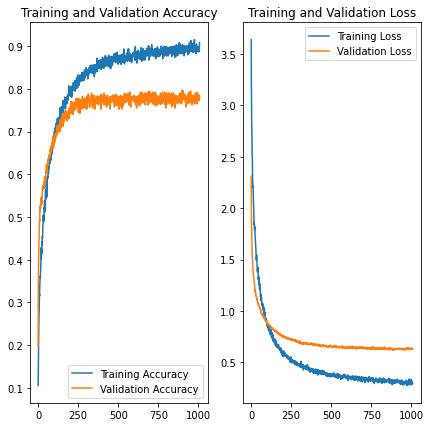

Training and validation loss for Original,Noise augmented group


In [44]:
# plot history graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(7, 7))
plt.subplot(1, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot( loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print('Training and validation loss for',','.join(augment_names), 'augmented group')

In [45]:
print('Mean accuracy:     '+str(np.mean(history.history['accuracy'])))
print('Mean val_accuracy: '+str(np.mean(history.history['val_accuracy'])))
print('Mean loss:         '+str(np.mean(history.history['loss'])))
print('Mean val_loss:     '+str(np.mean(history.history['val_loss'])))



Mean accuracy:     0.8234362863262652
Mean val_accuracy: 0.7505004884023496
Mean loss:         0.5174404417854116
Mean val_loss:     0.7174601984331227


In [46]:
# Extarcting features from test files
pre_train_models,dimension = get_model_group()
test_feature_array=[]
for pre_train_model in tqdm(pre_train_models):
    test_feature_array.append(extract_features(pre_train_model[0],pre_train_model[1],dimension,test_audio))


test_concatenate_features = np.concatenate(test_feature_array, axis=-1)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 128, 259, 3)]     0         
_________________________________________________________________
tf.math.truediv_6 (TFOpLambd (None, 128, 259, 3)       0         
_________________________________________________________________
tf.math.subtract_6 (TFOpLamb (None, 128, 259, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 4, 9, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1280)              0         
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________
8/8 [==============================] - 13s 1s/step
Model: "model_7"
_______________________________________________

In [47]:
# predecting class using the trained model
preds = train_model.predict(test_concatenate_features,batch_size=64)
preds1=preds.argmax(axis=1)
abc = preds1.astype(int).flatten()
predictions = (lb.inverse_transform((abc)))

In [48]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf.shape

(499, 1)

In [49]:
actualdf = pd.DataFrame({'actualvalues': test_audio_label_str})
actualdf[:10]
actualdf.index = range(len(actualdf.index))

In [50]:
finaldf = pd.concat([actualdf,preddf],axis=1)
finaldf.head()

,actualvalues,predictedvalues
0,male_sad,male_neutral
1,female_angry,female_angry
2,male_sad,male_sad
3,female_fearful,female_fearful
4,female_disgust,male_disgust


In [51]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (9,6), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [52]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

74.74949899799599

In [53]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

73.71360027994557

In [54]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

array([[35,  3,  0,  0,  0,  1,  0,  0,  0,  1,  0,  0],
       [ 0, 28,  0,  1,  3,  1,  0,  2,  0,  0,  0,  0],
       [ 0,  1, 37,  2,  4,  4,  0,  0,  1,  0,  0,  0],
       [ 2,  0,  1, 22,  2,  2,  0,  0,  1,  0,  0,  0],
       [ 0,  1,  0,  1, 59,  3,  0,  0,  0,  0,  0,  0],
       [ 0,  2,  2,  2, 14, 20,  0,  0,  0,  1,  0,  0],
       [ 4,  0,  0,  0,  0,  0, 37,  5,  0,  0,  1,  1],
       [ 0,  0,  0,  0,  0,  0,  1, 35,  0,  1,  1,  0],
       [ 0,  0,  1,  0,  0,  4,  0,  2, 18,  1,  3,  3],
       [ 0,  1,  0,  0,  0,  0,  2,  0,  5, 27,  2,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  2,  0,  1, 36,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  2,  5,  0, 18, 19]])

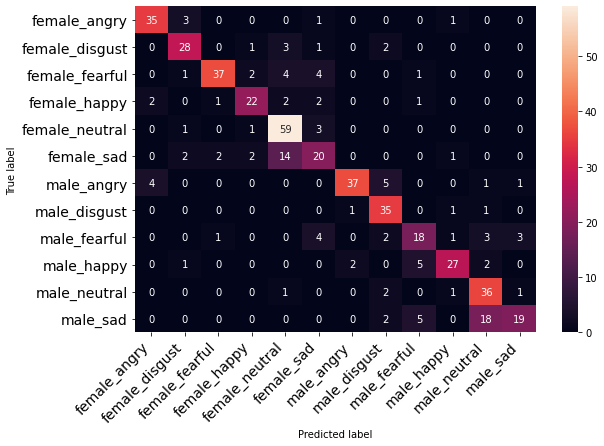

In [55]:
class_names=sorted(set(finaldf.actualvalues))
print_confusion_matrix(c, class_names)